In [ ]:
# !pip install patool
!pip install mediapipe


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.6/33.6 MB 28.6 MB/s eta 0:00:00


In [ ]:
import os
import numpy as np
from matplotlib import pyplot as plt
import cv2
import tensorflow as tf
import tensorflow.keras.layers as tfl
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, BatchNormalization, ReLU, Dropout, GRU, Conv2D, Conv1D, Flatten, Bidirectional, SimpleRNN
from tensorflow.keras.utils import to_categorical
import random 
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import mediapipe as mp
# import pickle as pk
from google.colab import drive
from google.colab import files

In [ ]:
drive.mount("/content/drive", force_remount=True)
%cd drive/MyDrive/Colab Notebooks/

Mounted at /content/drive
/content/drive/MyDrive/Colab Notebooks


In [ ]:
# !pip install patool
# import patoolib
# patoolib.extract_archive("./traindata/all_cut.rar", outdir="./traindata")

In [ ]:
mp_holistic = mp.solutions.holistic # Holistic model
mp_drawing = mp.solutions.drawing_utils # Drawing utilities

In [ ]:
holistic = mp_holistic.Holistic(
    static_image_mode=False,
    model_complexity=1,
    enable_segmentation=False,
    refine_face_landmarks=False,
    min_detection_confidence=0.2,
    min_tracking_confidence=0.2)

In [ ]:
def mediapipe_detection(image, model):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # COLOR CONVERSION BGR 2 RGB
    image.flags.writeable = False                  # Image is no longer writeable
    results = model.process(image)                 # Make prediction
    image.flags.writeable = True                   # Image is now writeable 
    return  results

In [ ]:
def normalize_zscore(pose, face, lh, rh):
       

    pose = (pose - pose.mean(axis=0))/(pose.std(axis=0) + 1e-7)
    face = (face -  face.mean(axis=0))/(face.std(axis=0) + 1e-7)
    lh = (lh - lh.mean(axis=0))/(lh.std(axis=0) + 1e-7)
    rh = (rh - rh.mean(axis=0))/(rh.std(axis=0) + 1e-7)

    return pose, face, lh, rh

In [ ]:
def extract_keypoints(results):

    # pose = np.array([[res.x, res.y, res.z] for res in results.pose_landmarks.landmark]) if results.pose_landmarks else np.zeros((33,3))
    # face = np.array([[res.x, res.y, res.z] for res in results.face_landmarks.landmark]) if results.face_landmarks else np.zeros((468,3))
    # lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]) if results.left_hand_landmarks else np.zeros((21,3))
    # rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]) if results.right_hand_landmarks else np.zeros((21,3))
    pose = np.array([[res.x, res.y] for res in results.pose_landmarks.landmark]) if results.pose_landmarks else np.zeros((33,2))
    face = np.array([[res.x, res.y] for res in results.face_landmarks.landmark]) if results.face_landmarks else np.zeros((468,2))
    lh = np.array([[res.x, res.y] for res in results.left_hand_landmarks.landmark]) if results.left_hand_landmarks else np.zeros((21,2))
    rh = np.array([[res.x, res.y] for res in results.right_hand_landmarks.landmark]) if results.right_hand_landmarks else np.zeros((21,2))

    pose, face, lh, rh = normalize_zscore(pose, face, lh, rh)
    face = face[:10,:]
    
    return np.concatenate([face.flatten(), pose.flatten(), lh.flatten(), rh.flatten()])
      

In [ ]:
def draw_styled_landmarks(image, results):
    # Draw face connections
    mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_TESSELATION, 
                             mp_drawing.DrawingSpec(color=(80,110,10), thickness=1, circle_radius=1), 
                             mp_drawing.DrawingSpec(color=(80,256,121), thickness=1, circle_radius=1)
                             ) 
    # Draw pose connections
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS,
                             mp_drawing.DrawingSpec(color=(80,22,10), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(80,44,121), thickness=2, circle_radius=2)
                             ) 
    # Draw left hand connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(121,22,76), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(121,44,250), thickness=2, circle_radius=2)
                             ) 
    # Draw right hand connections  
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2)
                             ) 

In [ ]:
def videoProc2(path, c=1, skip=0, o=False):
    "###"


    cap = cv2.VideoCapture(path)
    success = True
    
    framecount = 20

    fnum = 0
    v = []
    
    fpsCounter = 0


    while success:     
        success, frame = cap.read()
        
        if fpsCounter<=0:
            fpsCounter=c
        else:
            fpsCounter-=1           
            continue
        if fnum == framecount:
          break 
        
        if success:  
            # frame = cv2.resize(frame, (720,480), interpolation = cv2.INTER_AREA)
            results = mediapipe_detection(frame, holistic)

            eres = extract_keypoints(results)
            tmp = np.reshape(eres, (1,-1))
            v.append(tmp)

            fnum += 1
            if o:
                draw_styled_landmarks(frame, results)
                plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
                plt.show()


    
    v = np.reshape(v,(fnum,-1)) if fnum >0 else[]
        
    if fnum<framecount and fnum>0:
        tmp = np.zeros((framecount-fnum,170))
        v = np.concatenate((v, tmp), axis=0) 


    return v

***
***
***

In [ ]:
path ="./traindata/all"
file_list = os.listdir(path)
files = file_list
files.sort()

In [ ]:
len(files)

3200

In [ ]:
files = [path+"/"+f for f in files]# 
files[0],files[499]

('./traindata/all/001_001_001.mp4', './traindata/all/010_010_005.mp4')

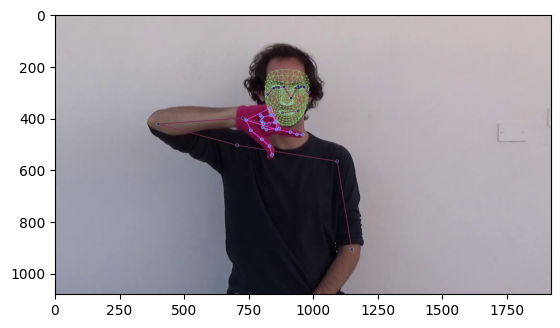

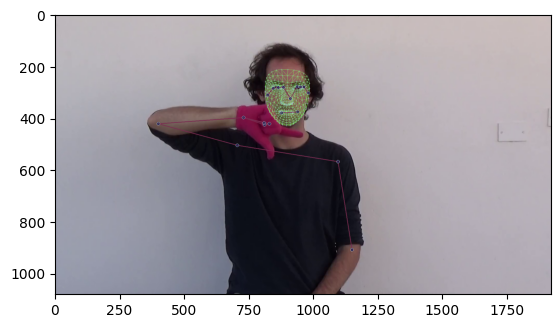

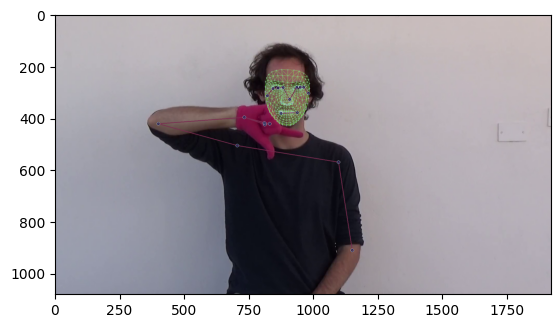

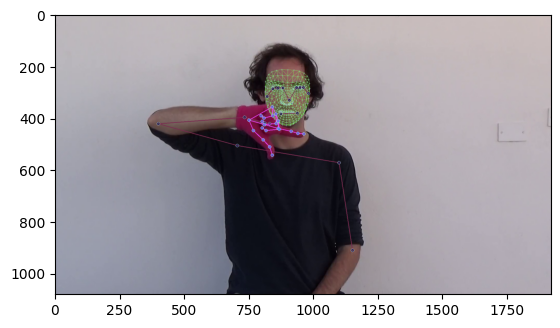

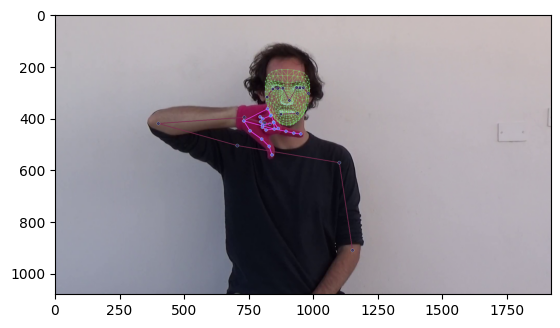

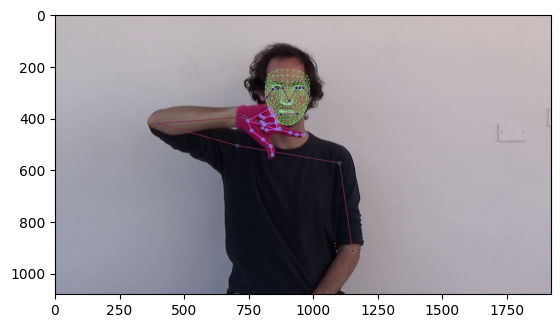

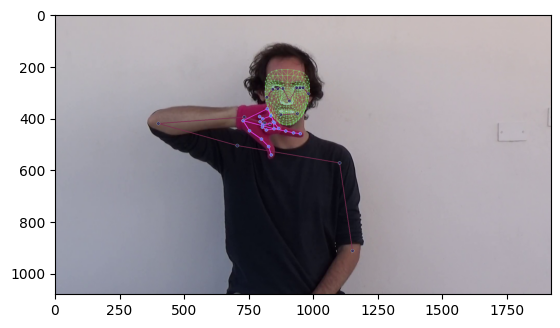

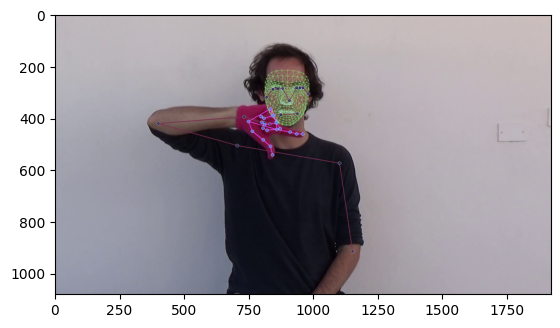

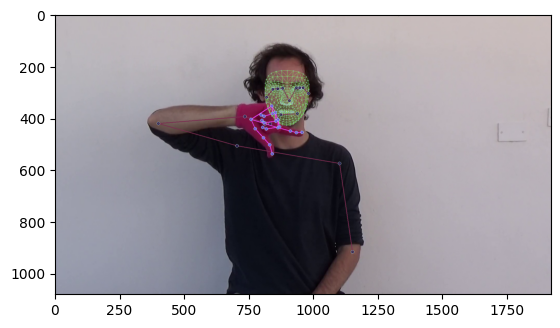

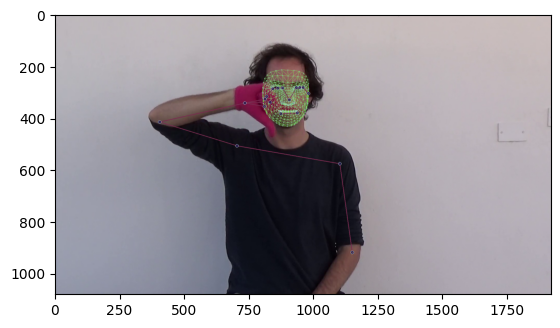

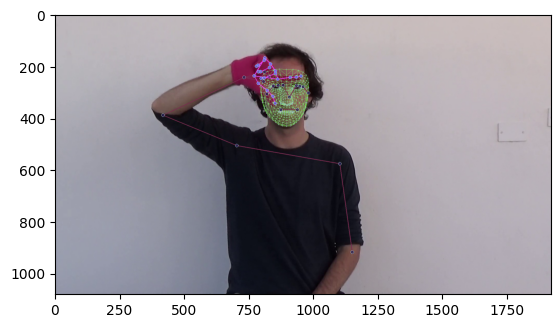

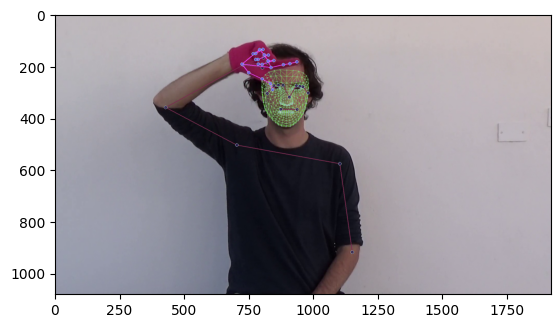

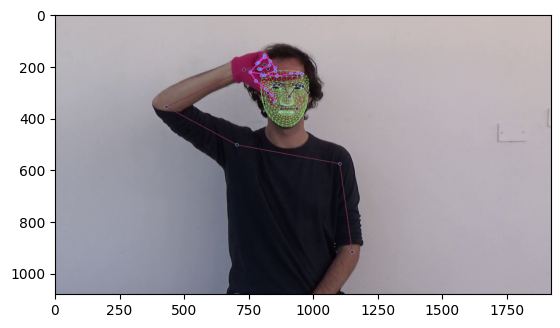

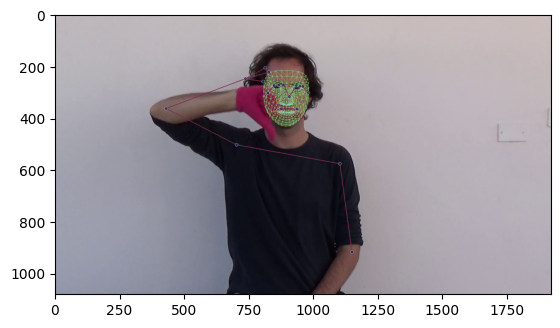

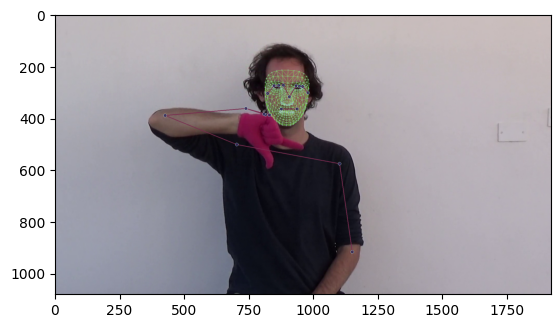

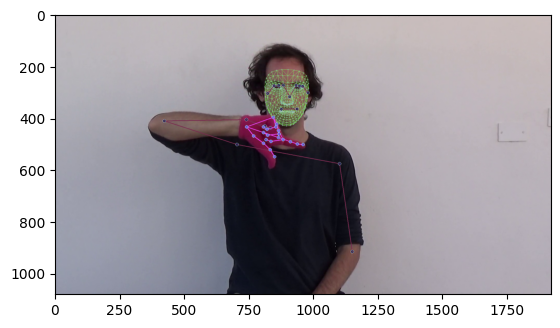

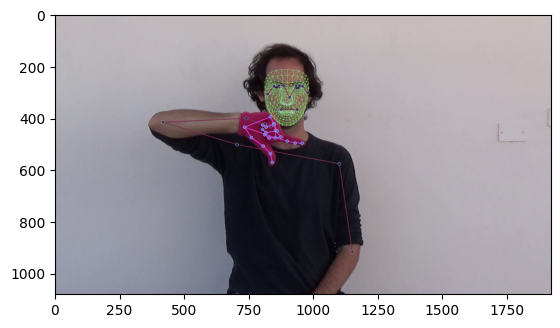

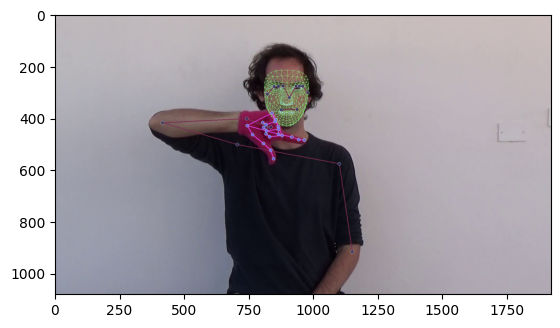

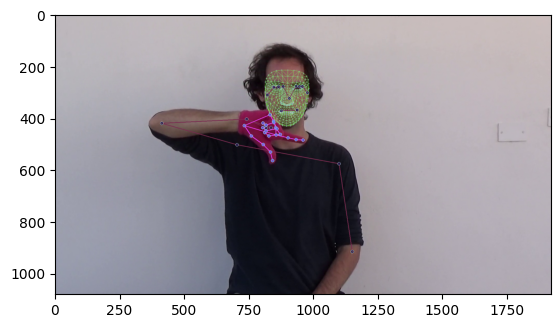

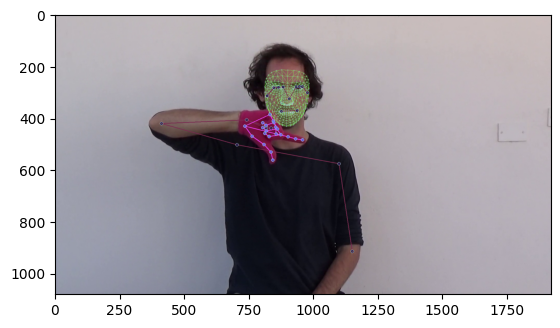

(20, 170)

In [ ]:
v= videoProc2(files[50],c=5,o=1)
v.shape

In [ ]:
v[14].max(),v[14].min(),

(1.9406185476483795, -3.2051501442505965)

In [ ]:
v[14].std(),v[14].mean()

(0.6569127806175497, -0.023651970306261802)

In [ ]:
sum = 0
for i in range(0,3200,25):
  v= videoProc2(files[i],c=5,o=0)
  sum+=v.shape[0]
  print(v.shape,int(i/50))


words={0:'Opaque',1:'Red',2:'Green',3:'Yellow',4:'Bright',5:'Light-blue	',6:'Colors',7:'Pink',8:'Women',9:'Enemy',10:'Son',11:'Man',12:'Away',13:'Drawer',14:'Born',15:'Learn',
       16:'Call',17:'Skimmer',18:'Bitter',19:'Sweet milk',20:'Milk',21:'Water',22:'Food',23:'Argentina',24:'Uruguay',25:'Country',26:'Last name',27:'Where',28:'Mock',
       29:'Birthday',30:'Breakfast',31:'Photo',32:'Hungry',33:'Map',34:'Coin',35:'Music',36:'Ship',37:'None',38:'Name',39:'Patience',40:'Perfume',41:'Deaf',42:'Trap',
       43:'Rice',44:'Barbecue',45:'Candy',46:'Chewing-gum',47:'Spaghetti',48:'Yogurt',49:'Accept',50:'Thanks',51:'Shut down',52:'Appear',53:'To land',54:'Catch',
       55:'Help',56:'Dance',57:'Bathe',58:'Buy',59:'Copy',60:'Run',61:'Realize',62:'Give',63:'Find'}

In [ ]:
words2={0:'Opaque',1:'Red',2:'Green',3:'Yellow',4:'Bright',5:'Light-blue',6:'Colors',7:'Pink',8:'Women',9:'Enemy',10:'Son',11:'Man',12:'Away',13:'Drawer',14:'Born',15:'Learn',
       16:'Call',17:'Skimmer',18:'Bitter',19:'Sweet milk',20:'Milk',21:'Water',22:'Food',23:'Argentina',24:'Uruguay',25:'Country',26:'Last name',27:'Where',
       29:'Birthday',32:'Hungry',36:'Ship',37:'None',38:'Name',39:'Patience',40:'Perfume',41:'Deaf',45:'Candy',46:'Chewing-gum'
       ,51:'Shut down',58:'Buy',61:'Realize',63:'Find'}

In [ ]:
words2l={}

In [ ]:
k=0
for i,w in words2.items():
  words2l[w]=k
  k+=1

In [ ]:
words2l

{'Opaque': 0,
 'Red': 1,
 'Green': 2,
 'Yellow': 3,
 'Bright': 4,
 'Light-blue': 5,
 'Colors': 6,
 'Pink': 7,
 'Women': 8,
 'Enemy': 9,
 'Son': 10,
 'Man': 11,
 'Away': 12,
 'Drawer': 13,
 'Born': 14,
 'Learn': 15,
 'Call': 16,
 'Skimmer': 17,
 'Bitter': 18,
 'Sweet milk': 19,
 'Milk': 20,
 'Water': 21,
 'Food': 22,
 'Argentina': 23,
 'Uruguay': 24,
 'Country': 25,
 'Last name': 26,
 'Where': 27,
 'Birthday': 28,
 'Hungry': 29,
 'Ship': 30,
 'None': 31,
 'Name': 32,
 'Patience': 33,
 'Perfume': 34,
 'Deaf': 35,
 'Candy': 36,
 'Chewing-gum': 37,
 'Shut down': 38,
 'Buy': 39,
 'Realize': 40,
 'Find': 41}

In [ ]:
l=0
X_train=[]
X_dev=[]
y_train=[]
y_dev=[]
files_ = files[1600:3200]
for f in files_:
    v= videoProc2(f,c=5,o=0)


    p = int(f.split('/')[-1].split('_')[1])
    if p <10:
      X_train.append(v)
      label = int(f.split('/')[-1].split('_')[0])-1
      y_train.append(label)
    else:
      X_dev.append(v)
      label = int(f.split('/')[-1].split('_')[0])-1
      y_dev.append(label)


    print(p, l)
    l+=1

    

1 0
1 1
1 2
1 3
1 4
2 5
2 6
2 7
2 8
2 9
3 10
3 11
3 12
3 13
3 14
4 15
4 16
4 17
4 18
4 19
5 20
5 21
5 22
5 23
5 24
6 25
6 26
6 27
6 28
6 29
7 30
7 31
7 32
7 33
7 34
8 35
8 36
8 37
8 38
8 39
9 40
9 41
9 42
9 43
9 44
10 45
10 46
10 47
10 48
10 49
1 50
1 51
1 52
1 53
1 54
2 55
2 56
2 57
2 58
2 59
3 60
3 61
3 62
3 63
3 64
4 65
4 66
4 67
4 68
4 69
5 70
5 71
5 72
5 73
5 74
6 75
6 76
6 77
6 78
6 79
7 80
7 81
7 82
7 83
7 84
8 85
8 86
8 87
8 88
8 89
9 90
9 91
9 92
9 93
9 94
10 95
10 96
10 97
10 98
10 99
1 100
1 101
1 102
1 103
1 104
2 105
2 106
2 107
2 108
2 109
3 110
3 111
3 112
3 113
3 114
4 115
4 116
4 117
4 118
4 119
5 120
5 121
5 122
5 123
5 124
6 125
6 126
6 127
6 128
6 129
7 130
7 131
7 132
7 133
7 134
8 135
8 136
8 137
8 138
8 139
9 140
9 141
9 142
9 143
9 144
10 145
10 146
10 147
10 148
10 149
1 150
1 151
1 152
1 153
1 154
2 155
2 156
2 157
2 158
2 159
3 160
3 161
3 162
3 163
3 164
4 165
4 166
4 167
4 168
4 169
5 170
5 171
5 172
5 173
5 174
6 175
6 176
6 177
6 178
6 179
7 180
7 181
7 1

In [ ]:
X_train = np.array(X_train)
y_train = np.array(y_train)
X_dev = np.array(X_dev)
y_dev = np.array(y_dev)

In [ ]:
X_train.shape,y_train.shape,X_dev.shape,y_dev.shape

((1440, 20, 170), (1440,), (160, 20, 170), (160,))

In [ ]:
np.save("./X_train_5.npy",X_train)
np.save("./y_train_5.npy",y_train)
np.save("./X_dev_5.npy",X_dev)
np.save("./y_dev_5.npy",y_dev)

In [ ]:
del files
del file_list

***
***
***

In [ ]:
# X_train = np.load("./traindata/X_train_1.npy")
# y_train = np.load("./traindata/y_train_1.npy")
# X_dev = np.load("./traindata/X_dev_1.npy")
# y_dev = np.load("./traindata/y_dev_1.npy")
X_train = np.load("./X_train_4.npy")
y_train = np.load("./y_train_4.npy")
X_dev = np.load("./X_dev_4.npy")
y_dev = np.load("./y_dev_4.npy")

In [ ]:
# X_train2 = np.load("./traindata/X_train_2.npy")
# y_train2 = np.load("./traindata/y_train_2.npy")
# X_dev2 = np.load("./traindata/X_dev_2.npy")
# y_dev2 = np.load("./traindata/y_dev_2.npy")
X_train2 = np.load("./X_train_5.npy")
y_train2 = np.load("./y_train_5.npy")
X_dev2 = np.load("./X_dev_5.npy")
y_dev2 = np.load("./y_dev_5.npy")

In [ ]:
X_train = np.concatenate([X_train,X_train2],axis=0)
y_train = np.concatenate([y_train,y_train2],axis=0)
X_dev = np.concatenate([X_dev,X_dev2],axis=0)
y_dev = np.concatenate([y_dev,y_dev2],axis=0)


In [ ]:
del X_train2
del y_train2
del X_dev2
del y_dev2

In [ ]:
X_train, y_train = shuffle(X_train, y_train, random_state=13)

X_dev, y_dev = shuffle(X_dev,  y_dev, random_state=13)

In [ ]:
m=X_train.mean()
s=(X_train.std()+1e-7)

In [ ]:
m,s

(-0.029721717741906344, 0.8175066647277758)

In [ ]:
# X_train = ((X_train - m)/ s)
# X_dev = (X_dev-m)/s

In [ ]:
# X_train = X_train[:,:,np.newaxis]
# X_dev = X_dev[:,:,np.newaxis]

In [ ]:
X_train[13].mean(),X_train[13].std(),X_train.shape

(-0.025967295482390424, 0.7044070341140912, (2880, 20, 170))

In [ ]:
X_train[3].min(),X_train[3].max(),X_train[3].shape

(-1.937381016551934, 3.1664970166720896, (20, 170))

In [ ]:
y_train[0:10],y_train.min(),y_train.max(),y_train.shape

(array([ 1, 52, 42, 13, 44, 29, 27,  8, 46, 45]), 0, 63, (2880,))

In [ ]:


# Bidirectional(GRU(128, return_sequences=True, activation='tanh')),
# BatchNormalization(axis=-1,center=True,scale=True,),
# ReLU(), 
# LSTM
# tf.keras.layers.SimpleRNN(256, return_sequences=True, activation="relu",),


# Dense(128, activation='relu',kernel_regularizer=tf.keras.regularizers.L1L2(0.01,0.05)),  
# # Dense(64, activation='relu',kernel_regularizer=tf.keras.regularizers.L1L2(0.01,0.05)),     recurrent_regularizer=tf.keras.regularizers.L1L2(1e-4,1e-2)
# BatchNormalization(axis=-1,center=True,scale=True,), recurrent_regularizer=tf.keras.regularizers.L1L2(1e-4,1e-4),


model_lstm_1 = Sequential([
tf.keras.Input(shape=(20,170),),


GRU(64, return_sequences=False, activation="relu",),
BatchNormalization(axis=-1,center=True,scale=True,),
Dense(128, activation='relu',kernel_regularizer=tf.keras.regularizers.L1L2(0.01,0.01)),
BatchNormalization(axis=-1,center=True,scale=True,),
Dropout(0.4),


Dense(64, activation='softmax')
])


In [ ]:

model_lstm_1.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_5 (GRU)                 (None, 96)                77184     
                                                                 
 batch_normalization_9 (Batc  (None, 96)               384       
 hNormalization)                                                 
                                                                 
 dense_9 (Dense)             (None, 128)               12416     
                                                                 
 batch_normalization_10 (Bat  (None, 128)              512       
 chNormalization)                                                
                                                                 
 dropout_5 (Dropout)         (None, 128)               0         
                                                                 
 dense_10 (Dense)            (None, 64)               

In [ ]:
callback1 = tf.keras.callbacks.EarlyStopping(monitor="val_loss", restore_best_weights=True, patience=20,mode="min")
callback2 = tf.keras.callbacks.EarlyStopping(monitor="val_sparse_categorical_accuracy", restore_best_weights=True,mode="max",patience=20)



In [ ]:
model_lstm_1.compile(tf.keras.optimizers.Adam(learning_rate=1e-3,beta_1=0.9,beta_2=0.999,epsilon=1e-07,)
        ,loss=tf.keras.losses.SparseCategoricalCrossentropy()
            ,metrics=["sparse_categorical_accuracy"])

In [ ]:
model_lstm_1.fit(X_train, y_train, epochs=1000, batch_size=128,callbacks=[callback2], validation_data=(X_dev, y_dev))#batch_size=64 ,#validation_data=(X_dev, y_dev)

Epoch 1/1000
23/23 [==============================] - 4s 69ms/step - loss: 14.0148 - sparse_categorical_accuracy: 0.1677 - val_loss: 13.2053 - val_sparse_categorical_accuracy: 0.1063
Epoch 2/1000
23/23 [==============================] - 1s 52ms/step - loss: 10.7216 - sparse_categorical_accuracy: 0.4993 - val_loss: 11.2182 - val_sparse_categorical_accuracy: 0.4406
Epoch 3/1000
23/23 [==============================] - 1s 52ms/step - loss: 8.3921 - sparse_categorical_accuracy: 0.6733 - val_loss: 9.4683 - val_sparse_categorical_accuracy: 0.5344
Epoch 4/1000
23/23 [==============================] - 1s 53ms/step - loss: 6.4789 - sparse_categorical_accuracy: 0.7872 - val_loss: 7.9520 - val_sparse_categorical_accuracy: 0.5875
Epoch 5/1000
23/23 [==============================] - 2s 78ms/step - loss: 4.8673 - sparse_categorical_accuracy: 0.8750 - val_loss: 6.7166 - val_sparse_categorical_accuracy: 0.5188
Epoch 6/1000
23/23 [==============================] - 2s 103ms/step - loss: 3.5955 - sparse

In [ ]:
model_lstm_1.evaluate(X_train, y_train)

90/90 [==============================] - 1s 8ms/step - loss: 0.1677 - sparse_categorical_accuracy: 0.9986


[0.16771717369556427, 0.9986110925674438]

In [ ]:
model_lstm_1.evaluate(X_dev, y_dev)

In [ ]:
model_lstm_1.save("./modelArgantine/final/v8_64_5.4")

In [ ]:
path ="./testdata/"
file_list = os.listdir(path)
file_list.sort()



In [ ]:
test1 = {}
for f in file_list:
  v=videoProc2(path+f,c=4,o=0)
  test1[f]=v
  print(f,v.shape)


Away.MP4 (20, 170)
Bitter.MP4 (20, 170)
Born.MP4 (20, 170)
Bright.mp4 (20, 170)
Call.MP4 (20, 170)
Colors.MP4 (20, 170)
Drawer.MP4 (20, 170)
Enemy.MP4 (20, 170)
Green.MP4 (20, 170)
Learn.MP4 (20, 170)
Light-blue.MP4 (20, 170)
Man.MP4 (20, 170)
Opaque.MP4 (20, 170)
Pink.MP4 (20, 170)
Red.MP4 (20, 170)
Skimmer.MP4 (20, 170)
Son.MP4 (20, 170)
Sweet milk.MP4 (20, 170)
Women.mp4 (20, 170)
Yellow.MP4 (20, 170)


In [ ]:
test2 = {}
for f in file_list: 
  v=videoProc2(path+f,c=2,o=0)
  test2[f]=v
  print(f,v.shape)

Away.MP4 (20, 170)
Bitter.MP4 (20, 170)
Born.MP4 (20, 170)
Bright.mp4 (20, 170)
Call.MP4 (20, 170)
Colors.MP4 (20, 170)
Drawer.MP4 (20, 170)
Enemy.MP4 (20, 170)
Green.MP4 (20, 170)
Learn.MP4 (20, 170)
Light-blue.MP4 (20, 170)
Man.MP4 (20, 170)
Opaque.MP4 (20, 170)
Pink.MP4 (20, 170)
Red.MP4 (20, 170)
Skimmer.MP4 (20, 170)
Son.MP4 (20, 170)
Sweet milk.MP4 (20, 170)
Women.mp4 (20, 170)
Yellow.MP4 (20, 170)


In [ ]:
test3 = {}
for f in file_list: 
  v=videoProc2(path+f,c=3,o=0)
  test3[f]=v
  print(f,v.shape)

Away.MP4 (20, 170)
Bitter.MP4 (20, 170)
Born.MP4 (20, 170)
Bright.mp4 (20, 170)
Call.MP4 (20, 170)
Colors.MP4 (20, 170)
Drawer.MP4 (20, 170)
Enemy.MP4 (20, 170)
Green.MP4 (20, 170)
Learn.MP4 (20, 170)
Light-blue.MP4 (20, 170)
Man.MP4 (20, 170)
Opaque.MP4 (20, 170)
Pink.MP4 (20, 170)
Red.MP4 (20, 170)
Skimmer.MP4 (20, 170)
Son.MP4 (20, 170)
Sweet milk.MP4 (20, 170)
Women.mp4 (20, 170)
Yellow.MP4 (20, 170)


In [ ]:
# reconstructed_model = tf.keras.models.load_model("./modelArgantine/v8.6")

In [ ]:
# reconstructed_model.summary()

In [ ]:
for l,v in test2.items():#model_lstm_1  # v  = (v-m)/s
  # v  = (v-v.mean())/(v.std()+1e-7)
  p = model_lstm_1.predict(np.reshape(v, (1,20,170)))
  pp =np.argmax(p)
  print(l,pp,p[:,pp],v[14].max())

In [ ]:
for l,v in test3.items():#model_lstm_1  # v  = (v-m)/s
  # v  = (v-m)/s
  p = model_lstm_1.predict(np.reshape(v, (1,20,170)))
  pp =np.argmax(p)
  print(l,pp,p[:,pp],v[14].max())

In [ ]:
for l,v in test1.items():#model_lstm_1  # v  = (v-m)/s
  p = model_lstm_1.predict(np.reshape(v, (1,20,170)))
  pp =np.argmax(p)
  print(l,pp,p[:,pp],v.std())